This notebook attempts to reproduce an implementation of the [DiffEdit](https://arxiv.org/abs/2210.11427) paper (based on the implementation by [Aayush Agrawal](https://aayushmnit.com/)). It assumes that you are already familiar with stable diffusion and hugging face difusers library. If not make sure to check the first lessons of [Practical Deep Learning for Coders part 2](https://course.fast.ai/Lessons/part2.html).

This notebook is building up on [the previous notebook about stable diffusion.](https://github.com/HaoES/stable-diffusion/blob/main/nbs/1%20-%20Negative_Prompts_and_Img_2_Img.ipynb)

N.B: You need a GPU to run this notebook, if you don't have an Nvidia GPU on your local machine you can use google colab.


# What is DiffEdit?:

DiffEdit is a method to take advantage of text-conditioned diffusion models for the task of semantic image editing, where the goal is to edit an image based on a text query. It takes three inputs:
- an input image.
- a caption describing the input image.
- a `text query` where you specify the editing to be done to your input image.  

DiffEdit is practicularly good if you just want to slightly edit an image without changing it completely.

![DiffEdit](https://raw.githubusercontent.com/HaoES/stable-diffusion/main/img/diffedit_intro.png)

This image illustrates how DiffEdit works, first we have an image of a bowl of fruits on a table, we want to edit the image so it has a bowl of pears instead of fruits. The model generates a mask over the fruits then proceeds to replace the fruits with pears and keep the other elements of the image.

![DiffEditProcess](https://raw.githubusercontent.com/HaoES/stable-diffusion/main/img/diffedit_fullprocess.png)

There are 3 main steps to the `DiffEdit` process:
- **Step 1:** given an image input we add noise to it, then we proceed to denoising it once using the reference/or unconditionally and once using the query text and we compute the normalized differences between these two denoising operations. After that we binarize this difference to create a mask.
- **Step 2:** We take the original image and encode it with DDIM
- **Step 3:** We denoise our image using the query step only on the masked area where the mask is active and in each step we add the noisy latent corresponding to the non masked area, that way only the masked zone is changed by the query prompt and the rest of the image stays the same as the original.

# Implementation:

## Required Libraries and helper functions:

As mentioned previously, this notebook assumes that you are already familiar with stable diffusion, so we will just import the required libraries and have some helper functions ready.

In [112]:
! pip install -Uqq fastcore transformers diffusers

Importing libraries

In [113]:
import torch, logging
logging.disable(logging.WARNING) # disable warning because huggingface is so verbose
# image libraries
from PIL import Image
from torchvision import transforms as tfms

# basic libraries
from fastdownload import FastDownload
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import shutil
import os

# video display
from IPython.display import HTML
from base64 import b64encode

## CLIP
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler

helper functions:

In [114]:
def load_components():
  """
  a helper functions that loads all the basic components of stable diffusion
  """
  vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", torch_dtype=torch.float16).to("cuda")
  unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")
  tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
  text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")
  scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
  return vae, unet, tokenizer, text_encoder, scheduler

def load_image(p):
  """
  a function that loads an image from a path
  """
  return Image.open(p).convert("RGB").resize((512,512))

def img_to_latent(image):
  """
  converts image to latent
  """
  init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
  init_image = init_image.to(device = 'cuda', dtype = torch.float16)
  init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
  return init_latent_dist

def latent_to_img(latent):
  """
  converts latent image
  """
  latent = (1 / 0.18215) * latent
  with torch.no_grad():
    image = vae.decode(latent).sample
  image = (image / 2 + 0.5).clamp(0,1)
  image = image.detach().cpu().permute(0,2,3,1).numpy()
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  return pil_images

def text_enc(prompts, maxlen = None):
  """
  convert text prompt to embedding
  """
  if maxlen is None: maxlen = tokenizer.model_max_length
  inp = tokenizer(prompts, padding = "max_length", max_length = maxlen, truncation = True, return_tensors = 'pt')
  return text_encoder(inp.input_ids.to('cuda'))[0].half()

vae, unet, tokenizer, text_encoder, scheduler = load_components()

Let's grab an image which will serve as a test for our implementation

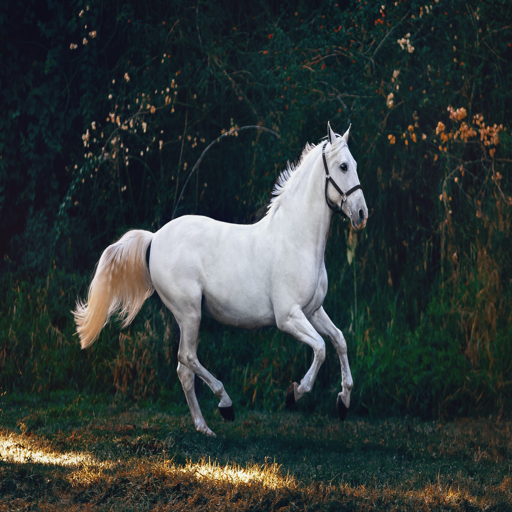

In [115]:
p = FastDownload().download('https://images.pexels.com/photos/1996333/pexels-photo-1996333.jpeg?cs=srgb&dl=pexels-helena-lopes-1996333.jpg&fm=jpg&_gl=1*1pc0nw8*_ga*OTk4MTI0MzE4LjE2NjY1NDQwMjE.*_ga_8JE65Q40S6*MTY2Njc1MjIwMC4yLjEuMTY2Njc1MjIwMS4wLjAuMA..')
img = load_image(p)
img

## First Step: Mask Creation

![step 1](https://raw.githubusercontent.com/HaoES/stable-diffusion/main/img/step1.png)

According to the paper, step 1 consists of three key parts:
- Denoising the image two times, once using reference text and using query text, we then take the difference between these two denoisings the idea is this difference would be pronounced in the area where they actually differ and there will be practicaly no difference in the area where our two objects of interests do not exist.
- This process is repeat for 10 iterations.
- We average these differences and binarize it to create a mask.

To start our implementation we first need to modify our `prompt_and_img_2_img` function from the [previous notebook](https://github.com/HaoES/stable-diffusion/blob/main/nbs/1%20-%20Negative_Prompts_and_Img_2_Img.ipynb) to return latents instead of full resolution denoised images.

In [116]:
def prompt_and_img_2_img(prompts, start_img, neg_prompt = None, g=7.5, seed = 100, strength = 0.8, steps = 50, dim = 512):
  """
  diffusion process from image and prompt to a latent
  """
  # convert text prompt to embedding
  text = text_enc(prompts)

  # adding an unconditional prompt
  if not neg_prompt: uncond = text_enc([""], text.shape[1])
  else: uncond = text_enc(neg_prompt, text.shape[1])
  emb = torch.cat([uncond, text])

  # Setting the seed
  if seed: torch.manual_seed(seed)

  # setting the number of steps in scheduler
  scheduler.set_timesteps(steps)

  # convert the initial image to latent
  init_latents = img_to_latent(start_img)

  # calculating initial timesteps based on the strength parameter
  init_timestep = int(steps * strength)
  timesteps = scheduler.timesteps[-init_timestep]
  timesteps = torch.tensor([timesteps], device='cuda')

  # adding noise to the latents
  noise = torch.randn(init_latents.shape, generator = None, device = 'cuda', dtype = init_latents.dtype)
  latents = scheduler.add_noise(init_latents, noise, timesteps)

  # computing the timesteps to start the diffusion loop
  t_start = max(steps - init_timestep, 0)
  timesteps = scheduler.timesteps[t_start:].to("cuda")

  # iterating through steps
  for i,ts in enumerate(tqdm(timesteps)):
    inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)

    # predicting the noise residual using Unet
    with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states = emb).sample.chunk(2)

    # performing guidance
    pred = u - g*(t-u)

    # conditioning the latents
    latents = scheduler.step(pred, ts, latents).prev_sample

  # returning the latent representation as an output array of 4x64x64
  return latents.detach().cpu()






Now we will create a `mask` function. This function takes as input an image as well as reference and query texts, the number of iterations and the `strength` parameter (according to the paper the defaults `n=10` for numbers of iterations and `strength = 0.5`).

The `mask` function performs the following steps:
1. Creates two denoised latents based respectively on the reference and query prompts and take the difference of them.
2. Repeats this process `n` number of times.
3. Averages and Standardizes these `n` differences.
4. Uses a threshold of `0.5` to binarize and create a mask.


In [117]:
def draw_mask(start_img, ref, query, n=10, s=0.5):
  # creating a dictionary to save the results for n iterations
  diff = {}

  # repeating the difference process n times
  for i in range(n):
    # denoised sample using original/reference text
    orig_noise = prompt_and_img_2_img(prompts = ref, start_img = start_img, strength = s, seed = 100*i)[0]
    # denoised sample using query text
    query_noise = prompt_and_img_2_img(prompts = query, start_img = start_img, strength = s, seed = 100*i)[0]
    # computing the difference
    diff[i] = (np.array(orig_noise) - np.array(query_noise))

  # creating an empty mask
  mask = np.zeros_like(diff[0])

  # taking an average over n iterations
  for i in range(n):
    mask += np.abs(diff[i])

  mask = mask.mean(0)

  # normalizing
  mask = (mask - mask.mean()) / np.std(mask)


  # binarizing and returning the mask
  return (mask > 0).astype("uint8")

mask = draw_mask(start_img= img, ref = ["image of a horse"], query = ["image of a zebra"], n = 10)



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Now let's display our mask on top of our image:

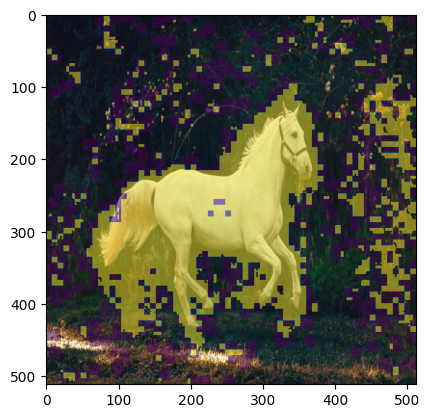

In [118]:
plt.imshow(np.array(img), cmap = 'gray')
plt.imshow(
    Image.fromarray(mask).resize((512,512)),
    cmap = 'viridis',
    alpha = 0.5*(np.array(Image.fromarray(m*255).resize((512,512)))> 0)
)

This looks quite well, the mask is covering the horse as intended!

## Step 2 and 3: Applying the masked diffusion

![step 2 and 3](https://raw.githubusercontent.com/HaoES/stable-diffusion/main/img/step23.png)

In step 2 and 3 the main idea is to denoise the latent only in the part where the mask is applied and keep the other part intact.

We create the `diffedit` function to do that:

In [119]:
def prompt_diffedit(ref, query, img, mask, g = 7.5, seed = 100, strength = 0.7, steps = 70, dim = 512):
  # converting prompts to embeddings
  rtext = text_enc(ref)
  qtext = text_enc(query)

  # adding an unconditionnal prompt
  uncond = text_enc([""], rtext.shape[1])
  emb = torch.cat([uncond, rtext, qtext])

  # setting the number of steps
  scheduler.set_timesteps(steps)

  # convert the image to latent
  init_latents = img_to_latent(img)

  # calculating timstep based on strength
  init_timestep = int(steps * strength)
  timesteps = scheduler.timesteps[-init_timestep]
  timesteps = torch.tensor([timesteps], device = 'cuda')

  # adding noise to the latents
  noise = torch.randn(init_latents.shape, generator = None, device = 'cuda', dtype = init_latents.dtype)
  latents = scheduler.add_noise(init_latents, noise, timesteps )

  # computing the timestep to start the diffusion loop
  t_start = max(steps - init_timestep, 0)
  timesteps = scheduler.timesteps[t_start:].to('cuda')

  # converting mask to torch tensor
  mask = torch.tensor(mask, dtype = unet.dtype).unsqueeze(0).unsqueeze(0).to('cuda')

  # iterating into defined steps
  for i, ts in enumerate(tqdm(timesteps)):
    # we scale the input latents to match the input of the unet
    inp = scheduler.scale_model_input(torch.cat([latents] * 3), ts)

    # predicting noise residuals using U-net
    with torch.no_grad(): u, r, q = unet(inp, ts, encoder_hidden_states = emb).sample.chunk(3)

    # performing guidance
    rpred = u + g*(r - u)
    qpred = u + g*(q - u)

    # conditioning the latents
    rlatents = scheduler.step(rpred, ts, latents).prev_sample
    qlatents = scheduler.step(qpred, ts, latents).prev_sample
    latents = mask*qlatents + (1 - mask) * rlatents

  # returning the final image
  return latent_to_img(latents)

now let's visualize the generated image

  0%|          | 0/35 [00:00<?, ?it/s]

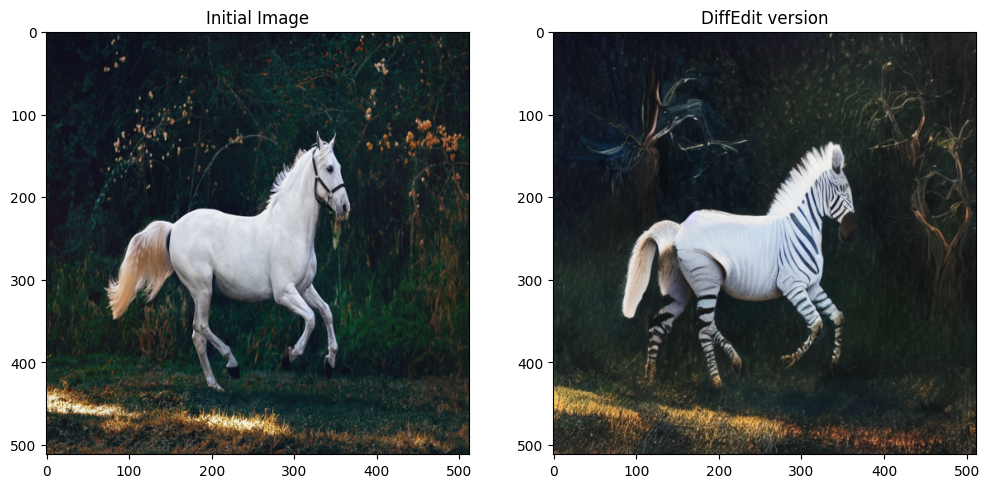

In [120]:
output = prompt_diffedit(
    ref = ["an image of a horse"],
    query = ["an image of a zebra"],
    img = img,
    mask = mask,
    g = 7.5, seed = 100, strength = 0.5, steps = 70, dim = 512)
# plotting side by side

fig, axs = plt.subplots(1, 2, figsize = (12,6))
for c, i in enumerate([img, output[0]]):
  axs[c].imshow(i)
  if c == 0: axs[c].set_title("Initial Image")
  else: axs[c].set_title("DiffEdit version")

Let's regroup this in one function:

In [121]:
def diffEdit(img, ref, query, g = 7.5, seed = 100, strength = 0.5, steps = 80, dim = 512):
  # Step 1: Create Mask
  m = draw_mask(start_img = img, ref = ref, query = query, n=10, s=0.5)

  # Step 2 and 3: Applying mask during diffusion process
  output = prompt_diffedit(
      ref = ref,
      query = query,
      img = img,
      mask = mask,
      g = g, seed = seed, strength = strength, steps = steps, dim = dim)
  return m, output

Let's also create a visualization function for `DiffEdit` displaying the original, masked and final output of `DiffEdit`

In [122]:
def viz_diffEdit(img, output, mask):
  # plotting side by side
  fig, axs =  plt.subplots(1, 3, figsize = (12,6))

  # plotting initial image
  axs[0].imshow(img)
  axs[0].set_title("Original Image")

  # plotting the mask
  axs[1].imshow(np.array(img), cmap='gray')
  axs[1].imshow(
      Image.fromarray(mask).resize((512,512)), ## Scaling the mask to original size
      cmap='cividis',
      alpha=0.5*(np.array(Image.fromarray(mask*255).resize((512,512))) > 0)
  )
  axs[1].set_title(f"DiffEdit mask")

  # plotting the final image
  axs[2].imshow(output[0])
  axs[2].set_title("Editted Image")

Let's test this!

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

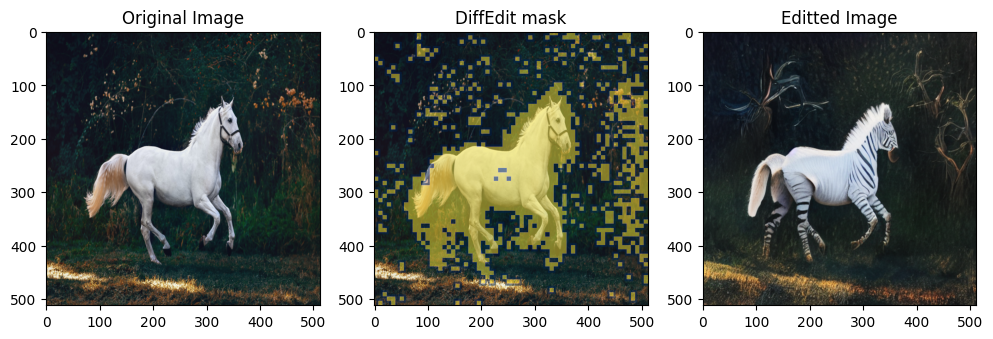

In [123]:
p = FastDownload().download('https://images.pexels.com/photos/1996333/pexels-photo-1996333.jpeg?cs=srgb&dl=pexels-helena-lopes-1996333.jpg&fm=jpg&_gl=1*1pc0nw8*_ga*OTk4MTI0MzE4LjE2NjY1NDQwMjE.*_ga_8JE65Q40S6*MTY2Njc1MjIwMC4yLjEuMTY2Njc1MjIwMS4wLjAuMA..')
img = load_image(p)
mask, output = diffEdit(img = img, ref = ["image of a horse"], query=["image of a zebra"])
viz_diffEdit(img, output, mask)

let's try another one:

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

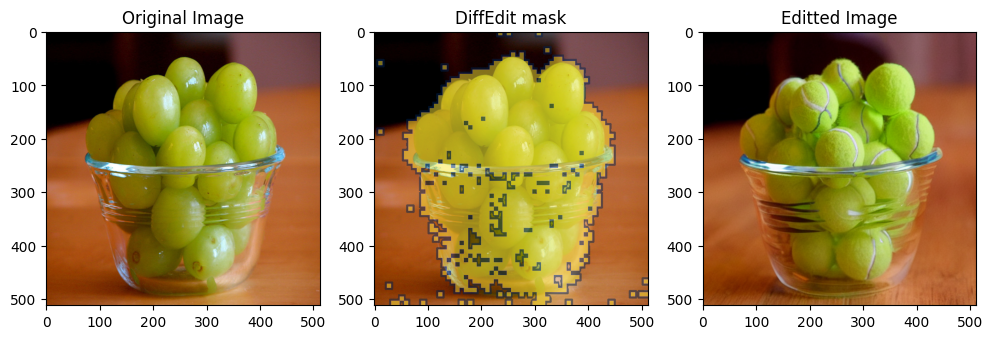

In [125]:
p = FastDownload().download('https://raw.githubusercontent.com/HaoES/stable-diffusion/main/img/grapes.JPG')
img = load_image(p)
mask, output = diffEdit(img = img, ref = ["Bowl of grapes"], query=["Bowl of tennis balls"])
viz_diffEdit(img, output, mask)

Perfect!

# Conclusion:

Implementing research papers can be pretty difficult, that's why I opted to start first with re-implementation to learn the necessary skills/habits to be able to implement them from scratch by my own.